## 2. ML Feature Transformations

- In this notebook, we will walk through a few transformations that are included in the Snowflake ML Preprocessing API. 
- We will also build a preprocessing pipeline to be used in the ML modeling notebook.

***Note: All feature transformations using Snowflake ML are distributed operations in the same way that Snowpark DataFrame operations are.***

### Import Libraries

In [1]:
# [MB] To setup explicit connection
import os
from dotenv import load_dotenv
from snowflake.snowpark import Session

# Snowpark for Python
# import snowflake.snowpark.functions as F
from snowflake.snowpark.types import DecimalType

# Snowflake ML
from snowflake.ml.modeling.pipeline import Pipeline  # type: ignore
import snowflake.ml.modeling.preprocessing as snowml
from snowflake.ml.modeling.metrics.correlation import correlation

# Data science libs
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Misc
# import json
import joblib
import warnings

# Warning suppression
warnings.simplefilter('ignore')

In [2]:
# [MB] Load environment variables
load_dotenv()
USER = os.getenv('SNOWSQL_USER')
ACCOUNT = os.getenv('SNOWSQL_ACCOUNT')
PASSWORD = os.getenv('SNOWSQL_PWD')

### Establish Secure Connection to Snowflake

Notebooks establish a Snowpark Session when the notebook is attached to the kernel. Let's use that Session object to validate our connection.

In [3]:
# [MB] Can't run SQL inside Jupyter notebook. Instead set in following cell.
# -- Using Warehouse, Database, and Schema created during Setup
# USE WAREHOUSE ML_HOL_WH;
# USE DATABASE ML_HOL_DB;
# USE SCHEMA ML_HOL_SCHEMA;

In [51]:
# [MB] Create a Snowpark session explicitly
connection_parameters = {
    "account": ACCOUNT,
    "user": USER,
    "password": PASSWORD,
    "role": "ML_MODEL_HOL_USER",
    "warehouse": "ML_HOL_WH",
    "database": "ML_HOL_DB",
    "schema": "ML_HOL_SCHEMA"
}
session = Session.builder.configs(connection_parameters).create()

# session = get_active_session()

# Add a query tag to the session.
# session.query_tag = {
#     "origin": "sf_sit-is", 
#     "name": "e2e_ml_snowparkpython",
#     "version":{"major": 1, "minor": 0,},
#     "attributes": {"is_quickstart": 1}}
session

### Data Loading

In [5]:
# First, we read in the data from a Snowflake table into a Snowpark DataFrame
# Note: change this only if you named your table in the data ingest notebook.
diamonds_df = session.table("DIAMONDS")

### Feature Transformations

We will illustrate a few of the transformation functions here, but the rest can be found in the [documentation](https://docs.snowflake.com/LIMITEDACCESS/snowflake-ml-preprocessing).

##### Let's use the `MinMaxScaler` to normalize the `CARAT` column.

In [6]:
# Normalize the CARAT column
snowml_mms = snowml.MinMaxScaler(  # type: ignore
    input_cols=["CARAT"],
    output_cols=["CARAT_NORM"]
)
normalized_diamonds_df = snowml_mms.fit(diamonds_df).transform(diamonds_df)

# Reduce the number of decimals
new_col = normalized_diamonds_df.col("CARAT_NORM").cast(DecimalType(7, 6))
normalized_diamonds_df = normalized_diamonds_df.with_column(
    "CARAT_NORM",
    new_col
)

normalized_diamonds_df.to_pandas()

,COLOR,CLARITY,PRICE,CUT,CARAT,X,Y,Z,DEPTH,TABLE_PCT,CARAT_NORM
0,E,SI2,326,IDEAL,0.23,3.95,3.98,2.43,61.5,55.0,0.006237
1,E,SI1,326,PREMIUM,0.21,3.89,3.84,2.31,59.8,61.0,0.002079
2,E,VS1,327,GOOD,0.23,4.05,4.07,2.31,56.9,65.0,0.006237
3,I,VS2,334,PREMIUM,0.29,4.20,4.23,2.63,62.4,58.0,0.018711
4,J,SI2,335,GOOD,0.31,4.34,4.35,2.75,63.3,58.0,0.022869
...,...,...,...,...,...,...,...,...,...,...,...
53935,D,SI1,2757,IDEAL,0.72,5.75,5.76,3.50,60.8,57.0,0.108108
53936,D,SI1,2757,GOOD,0.72,5.69,5.75,3.61,63.1,55.0,0.108108
53937,D,SI1,2757,VERY_GOOD,0.70,5.66,5.68,3.56,62.8,60.0,0.103950
53938,H,SI2,2757,PREMIUM,0.86,6.15,6.12,3.74,61.0,58.0,0.137214


##### Let's use the `OrdinalEncoder` to transform `COLOR` and `CLARITY` from categorical to numerical values so they are more meaningful.

In [7]:
# Encode CUT and CLARITY, preserving ordinal importance
categories = {
    "CUT": np.array(
        ["IDEAL", "PREMIUM", "VERY_GOOD", "GOOD", "FAIR"]
    ),
    "CLARITY": np.array(
        ["IF", "VVS1", "VVS2", "VS1", "VS2", "SI1", "SI2", "I1", "I2", "I3"]
    ),
}

snowml_oe = snowml.OrdinalEncoder(  # type: ignore
    input_cols=["CUT", "CLARITY"],
    output_cols=["CUT_OE", "CLARITY_OE"],
    categories=categories
)
ord_encoded_diamonds_df = snowml_oe.fit(
    normalized_diamonds_df
).transform(normalized_diamonds_df)

# Show the encoding
print(snowml_oe._state_pandas)

ord_encoded_diamonds_df.to_pandas()

   _COLUMN_NAME  _CATEGORY  _INDEX
0           CUT      IDEAL       0
1           CUT    PREMIUM       1
2           CUT  VERY_GOOD       2
3           CUT       GOOD       3
4           CUT       FAIR       4
5       CLARITY         IF       0
6       CLARITY       VVS1       1
7       CLARITY       VVS2       2
8       CLARITY        VS1       3
9       CLARITY        VS2       4
10      CLARITY        SI1       5
11      CLARITY        SI2       6
12      CLARITY         I1       7
13      CLARITY         I2       8
14      CLARITY         I3       9


,CUT_OE,CLARITY_OE,COLOR,CLARITY,PRICE,CUT,CARAT,X,Y,Z,DEPTH,TABLE_PCT,CARAT_NORM
0,0.0,6.0,E,SI2,326,IDEAL,0.23,3.95,3.98,2.43,61.5,55.0,0.006237
1,1.0,5.0,E,SI1,326,PREMIUM,0.21,3.89,3.84,2.31,59.8,61.0,0.002079
2,3.0,3.0,E,VS1,327,GOOD,0.23,4.05,4.07,2.31,56.9,65.0,0.006237
3,1.0,4.0,I,VS2,334,PREMIUM,0.29,4.20,4.23,2.63,62.4,58.0,0.018711
4,3.0,6.0,J,SI2,335,GOOD,0.31,4.34,4.35,2.75,63.3,58.0,0.022869
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,0.0,5.0,D,SI1,2757,IDEAL,0.72,5.75,5.76,3.50,60.8,57.0,0.108108
53936,3.0,5.0,D,SI1,2757,GOOD,0.72,5.69,5.75,3.61,63.1,55.0,0.108108
53937,2.0,5.0,D,SI1,2757,VERY_GOOD,0.70,5.66,5.68,3.56,62.8,60.0,0.103950
53938,1.0,6.0,H,SI2,2757,PREMIUM,0.86,6.15,6.12,3.74,61.0,58.0,0.137214


##### Let's use the `OneHotEncoder` to transform the categorical columns to numerical columns.

This is more for illustration purposes. Using the OrdinalEncoder makes more sense for the diamonds dataset since `CARAT`, `COLOR`, and `CLARITY` all follow a natural ranking order.

In [8]:
# Encode categoricals to numeric columns
snowml_ohe = snowml.OneHotEncoder(  # type: ignore
    input_cols=["CUT", "COLOR", "CLARITY"],
    output_cols=["CUT_OHE", "COLOR_OHE", "CLARITY_OHE"]
)
transformed_diamonds_df = snowml_ohe.fit(
    ord_encoded_diamonds_df
).transform(ord_encoded_diamonds_df)

np.array(transformed_diamonds_df.columns)

array(['CUT_OHE_FAIR', 'CUT_OHE_GOOD', 'CUT_OHE_IDEAL', 'CUT_OHE_PREMIUM',
       'CUT_OHE_VERY_GOOD', 'COLOR_OHE_D', 'COLOR_OHE_E', 'COLOR_OHE_F',
       'COLOR_OHE_G', 'COLOR_OHE_H', 'COLOR_OHE_I', 'COLOR_OHE_J',
       'CLARITY_OHE_I1', 'CLARITY_OHE_IF', 'CLARITY_OHE_SI1',
       'CLARITY_OHE_SI2', 'CLARITY_OHE_VS1', 'CLARITY_OHE_VS2',
       'CLARITY_OHE_VVS1', 'CLARITY_OHE_VVS2', 'CUT_OE', 'CLARITY_OE',
       'COLOR', 'CLARITY', 'PRICE', 'CUT', 'CARAT', 'X', 'Y', 'Z',
       'DEPTH', 'TABLE_PCT', 'CARAT_NORM'], dtype='<U17')

##### Finally, we can also build out a full preprocessing `Pipeline`.

This will be useful for both the ML training & inference steps to have standardized feature transformations.

In [ ]:
# Categorize all the features for processing
CATEGORICAL_COLUMNS = ["CUT", "COLOR", "CLARITY"]
CATEGORICAL_COLUMNS_OE = ["CUT_OE", "COLOR_OE", "CLARITY_OE"]  # Ord. encoded
NUMERICAL_COLUMNS = ["CARAT", "DEPTH", "TABLE_PCT", "X", "Y", "Z"]

categories = {
    "CUT": np.array(
        ["IDEAL", "PREMIUM", "VERY_GOOD", "GOOD", "FAIR"]
    ),
    "CLARITY": np.array(
        ["IF", "VVS1", "VVS2", "VS1", "VS2", "SI1", "SI2", "I1", "I2", "I3"]
    ),
    "COLOR": np.array(
        ['D', 'E', 'F', 'G', 'H', 'I', 'J']
    ),
}

In [10]:
# Build the pipeline
preprocessing_pipeline = Pipeline(
    steps=[
        (
            "OE",
            snowml.OrdinalEncoder(  # type: ignore
                input_cols=CATEGORICAL_COLUMNS,
                output_cols=CATEGORICAL_COLUMNS_OE,
                categories=categories,
            )
        ),
        (
            "MMS",
            snowml.MinMaxScaler(  # type: ignore
                clip=True,
                input_cols=NUMERICAL_COLUMNS,
                output_cols=NUMERICAL_COLUMNS,
            )
        )
    ]
)

# We are just pickling it locally first
PIPELINE_FILE = '/tmp/preprocessing_pipeline.joblib'
joblib.dump(preprocessing_pipeline, PIPELINE_FILE)

transformed_diamonds_df = preprocessing_pipeline.fit(
    diamonds_df
).transform(diamonds_df)

transformed_diamonds_df.to_pandas()

,CARAT,DEPTH,TABLE_PCT,X,Y,Z,CUT_OE,COLOR_OE,CLARITY_OE,COLOR,CLARITY,PRICE,CUT
0,0.006237,0.513889,0.230769,0.367784,0.067572,0.076415,0.0,1.0,6.0,E,SI2,326,IDEAL
1,0.002079,0.466667,0.346154,0.362197,0.065195,0.072642,1.0,1.0,5.0,E,SI1,326,PREMIUM
2,0.006237,0.386111,0.423077,0.377095,0.069100,0.072642,3.0,1.0,3.0,E,VS1,327,GOOD
3,0.018711,0.538889,0.288462,0.391061,0.071817,0.082704,1.0,5.0,4.0,I,VS2,334,PREMIUM
4,0.022869,0.563889,0.288462,0.404097,0.073854,0.086478,3.0,6.0,6.0,J,SI2,335,GOOD
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,0.108108,0.494444,0.269231,0.535382,0.097793,0.110063,0.0,0.0,5.0,D,SI1,2757,IDEAL
53936,0.108108,0.558333,0.230769,0.529795,0.097623,0.113522,3.0,0.0,5.0,D,SI1,2757,GOOD
53937,0.103950,0.550000,0.326923,0.527002,0.096435,0.111950,2.0,0.0,5.0,D,SI1,2757,VERY_GOOD
53938,0.137214,0.500000,0.288462,0.572626,0.103905,0.117610,1.0,4.0,6.0,H,SI2,2757,PREMIUM


In [12]:
# You can also save the pickled object into the stage we created earlier
# for deployment.
session.file.put(PIPELINE_FILE, "@ML_HOL_ASSETS", overwrite=True)

[PutResult(source='preprocessing_pipeline.joblib', target='preprocessing_pipeline.joblib.gz', source_size=2104, target_size=1152, source_compression='NONE', target_compression='GZIP', status='UPLOADED', message='')]

### Data Exploration

Now that we've transformed our features, let's calculate the correlation using Snowflake ML's `correlation()` function between each pair to better understand their relationships.

*Note: Snowflake ML's pearson correlation function returns a Pandas DataFrame*

In [ ]:
# [MB] FIXME: versioning conflict when running snowflake.ml correlation metric
# corr_diamonds_df = correlation(df=transformed_diamonds_df)
# corr_diamonds_df

# transformed_diamonds_df.to_pandas().corr()
numeric_cols = (
    transformed_diamonds_df
    .to_pandas()
    .select_dtypes(include='number')
)
corr_diamonds_df = numeric_cols.corr()
corr_diamonds_df

,CARAT,DEPTH,TABLE_PCT,X,Y,Z,CUT_OE,COLOR_OE,CLARITY_OE,PRICE
CARAT,1.000000,0.028224,0.181618,0.975094,0.951722,0.953387,0.134967,0.291437,0.352841,0.921591
DEPTH,0.028224,1.000000,-0.295779,-0.025289,-0.029341,0.094924,0.218055,0.047279,0.067384,-0.010647
TABLE_PCT,0.181618,-0.295779,1.000000,0.195344,0.183760,0.150929,0.433405,0.026465,0.160327,0.127134
X,0.975094,-0.025289,0.195344,1.000000,0.974701,0.970772,0.125565,0.270287,0.371999,0.884435
Y,0.951722,-0.029341,0.183760,0.974701,1.000000,0.952006,0.121462,0.263584,0.358420,0.865421
Z,0.953387,0.094924,0.150929,0.970772,0.952006,1.000000,0.149323,0.268227,0.366952,0.861249
CUT_OE,0.134967,0.218055,0.433405,0.125565,0.121462,0.149323,1.000000,0.020519,0.189175,0.053491
COLOR_OE,0.291437,0.047279,0.026465,0.270287,0.263584,0.268227,0.020519,1.000000,-0.025631,0.172511
CLARITY_OE,0.352841,0.067384,0.160327,0.371999,0.358420,0.366952,0.189175,-0.025631,1.000000,0.146800
PRICE,0.921591,-0.010647,0.127134,0.884435,0.865421,0.861249,0.053491,0.172511,0.146800,1.000000


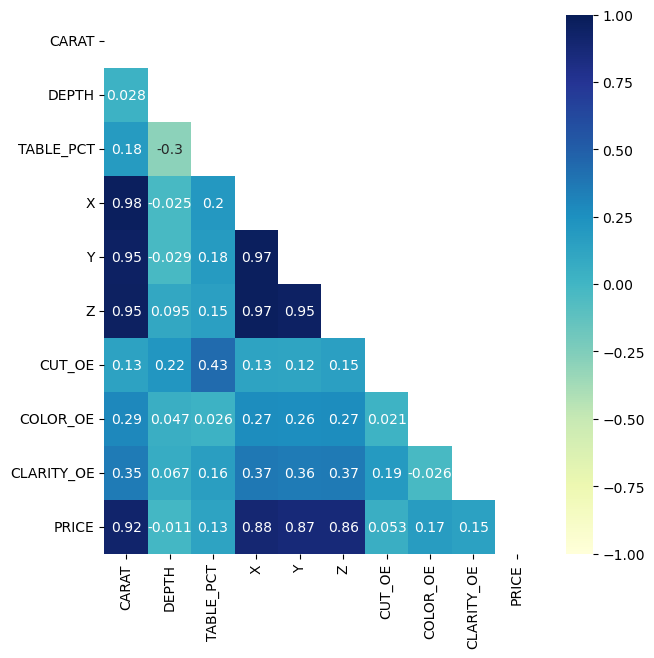

In [44]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_diamonds_df, dtype=bool))

# Create a heatmap with the features
plt.figure(figsize=(7, 7))
heatmap = sns.heatmap(
    corr_diamonds_df,
    mask=mask,
    cmap="YlGnBu",
    annot=True,
    vmin=-1,
    vmax=1
)

We note that `CARAT` and `PRICE` are highly correlated, which makes sense! Let's take a look at their relationship a bit closer.

*Note: You will have to convert your Snowpark DF to a Pandas DF in order to use matplotlib & seaborn.*

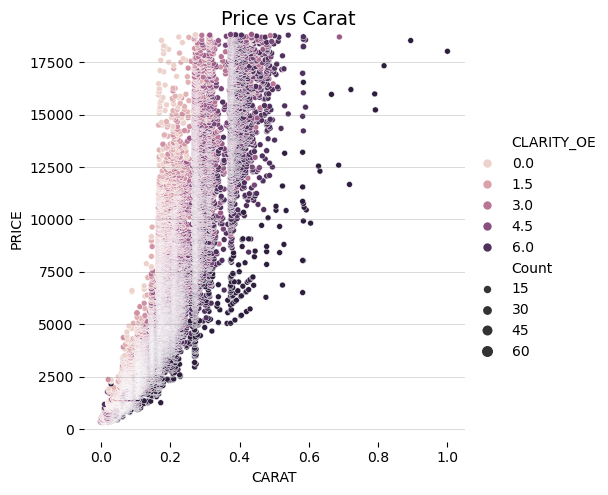

In [50]:
# Set up a plot to look at CARAT and PRICE
counts = (
    transformed_diamonds_df.to_pandas()
    .groupby(['PRICE', 'CARAT', 'CLARITY_OE'])
    .size()
    .reset_index(name='Count')
)

# fig, ax = plt.subplots(figsize=(20, 20))
# plt.title('Price vs Carat', fontsize=28)
# ax = sns.scatterplot(
ax = sns.relplot(
    data=counts,
    x='CARAT',
    y='PRICE',
    size='Count',
    hue='CLARITY_OE',
    kind='scatter',
    markers='o'
)
ax.fig.suptitle('Price vs Carat', fontsize=14)
ax.ax.grid(axis='y', color='gray', linestyle='-', linewidth=.5, alpha=.4)
# ax.grid(axis='y')

# The relationship is not linear - it appears exponential,
# which makes sense given the rarity of the large diamonds.
sns.despine(left=True, bottom=True)

In the next notebook, we will look at how you can train an XGBoost model with the diamonds dataset.